In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import TextVectorization, Embedding, MaxPooling2D, LSTM, SpatialDropout1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.data import Dataset

# Data Loading

In [79]:
df_dev = pd.read_csv("dataset\subtaskA_clean_dev_cased.csv")
df_dev.head()

,comment_text,conspiratorial
0,Se non ci fossero soldati non ci sarebbero gue...,0
1,"]( ""Shedding of Infectious SARS-CoV-2 Des...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [80]:
list(df_dev['comment_text'])

['Se non ci fossero soldati non ci sarebbero guerre.',
 '](      "Shedding of Infectious SARS-CoV-2 Despite Vaccination"  "Diffusione del SARS-CoV-2 nonostante la vaccinazione"     "La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale.  le indagini sull\'epidemia suggeriscono che le persone vaccinate possono diffondere  Delta"   " questi risultati indicano che anche le persone asintomatiche e comple vaccinate possono diffondere il virus infettivo."   " questi dati indicano che gli individui vaccinati e non vaccinati infettati dalla variante Delta possono trasmettere l\'infezione."',
 'PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA VERITA\' La scorsa settimana Elon Musk ha dichiarato di volere che la "libertà di parola" sui social media sia tutelata ai sensi della Legge del Paese. I DEM sono spaventatissimi dalla scelta coraggiosa del magnate dello Spazio di acquistare Twitter  così scon

In [81]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    1840 non-null   object
 1   conspiratorial  1840 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.9+ KB


In [82]:
df_dev.conspiratorial.value_counts()

1    925
0    915
Name: conspiratorial, dtype: int64

Il task è bilanciato.

In [83]:
df_dev.iloc[(1, 0)]

'](      "Shedding of Infectious SARS-CoV-2 Despite Vaccination"  "Diffusione del SARS-CoV-2 nonostante la vaccinazione"     "La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale.  le indagini sull\'epidemia suggeriscono che le persone vaccinate possono diffondere  Delta"   " questi risultati indicano che anche le persone asintomatiche e comple vaccinate possono diffondere il virus infettivo."   " questi dati indicano che gli individui vaccinati e non vaccinati infettati dalla variante Delta possono trasmettere l\'infezione."'

# Additional Text Preprocessing

In [84]:
import re

In [85]:
import nltk

In [86]:
from nltk.corpus import stopwords

In [87]:
print(stopwords.words('italian'))

['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho', 'hai', 'ha', 'ab

In [88]:
STOPWORDS = set(stopwords.words('italian'))

In [89]:
def clean_text(text):
    """ text: a string
        return: modified initial string """
    text = text.lower() # lowercase text
    text = re.sub(r'[/(){}\[\]\|@,;]', ' ', text) # substitute the matched string with space.
    text = re.sub(r'[#+_]', '', text) # substitute bad symbols with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df_dev['comment_text'] = df_dev['comment_text'].apply(clean_text)
df_dev['comment_text'] = df_dev['comment_text'].str.replace('\d+', '')


C:\Users\irene\AppData\Local\Temp\ipykernel_9864\3452721758.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df_dev['comment_text'] = df_dev['comment_text'].str.replace('\d+', '')


In [90]:
#%pip install wordcloud

In [91]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [92]:
conspiratorial_msg_text = ''
for conspiratorial_post in list(df_dev[df_dev['conspiratorial'] == 1].comment_text):
    conspiratorial_msg_text += conspiratorial_post

In [93]:
conspiratorial_msg_text

'"shedding of infectious sars-cov- despite vaccination" "diffusione sars-cov- nonostante vaccinazione" "la variante delta sars-cov- può causare elevate cariche virali trasmissibile contiene mutazioni conferiscono fuga immunitaria parziale. indagini sull\'epidemia suggeriscono persone vaccinate possono diffondere delta" " risultati indicano persone asintomatiche comple vaccinate possono diffondere virus infettivo." " dati indicano individui vaccinati vaccinati infettati variante delta possono trasmettere l\'infezione."paura delirio cnn: ministero verita\' scorsa settimana elon musk dichiarato volere "libertà parola" social media tutelata sensi legge paese. dem spaventatissimi scelta coraggiosa magnate spazio acquistare twitter così scontrandosi frontalmente senza paura blackrock vanguard state street cioè tre fondi inves controllano % multinazionali prime  mondo. dem americani risposto grande sorella hillary grande fratello obama quali twittando ordinato allestire opportuni apparati cen

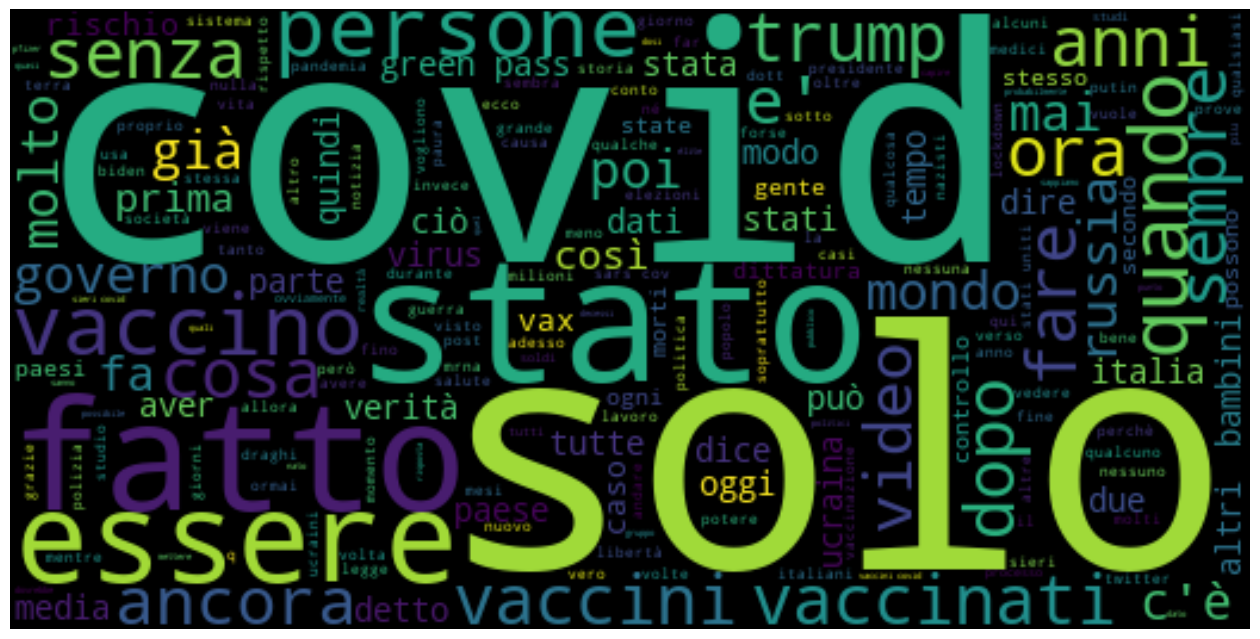

In [94]:
conspiratorial_msg_cloud = WordCloud(width=520,
                                     height=260,
                                     stopwords=STOPWORDS,
                                     #max_font_size=50,
                                     #background_color = "black", colormap = 'Pastel1'
                                     ).generate(conspiratorial_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(conspiratorial_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

In [95]:
not_conspiratorial_msg_text = ''
for not_conspiratorial_post in list(df_dev[df_dev['conspiratorial'] == 0].comment_text):
    not_conspiratorial_msg_text += not_conspiratorial_post

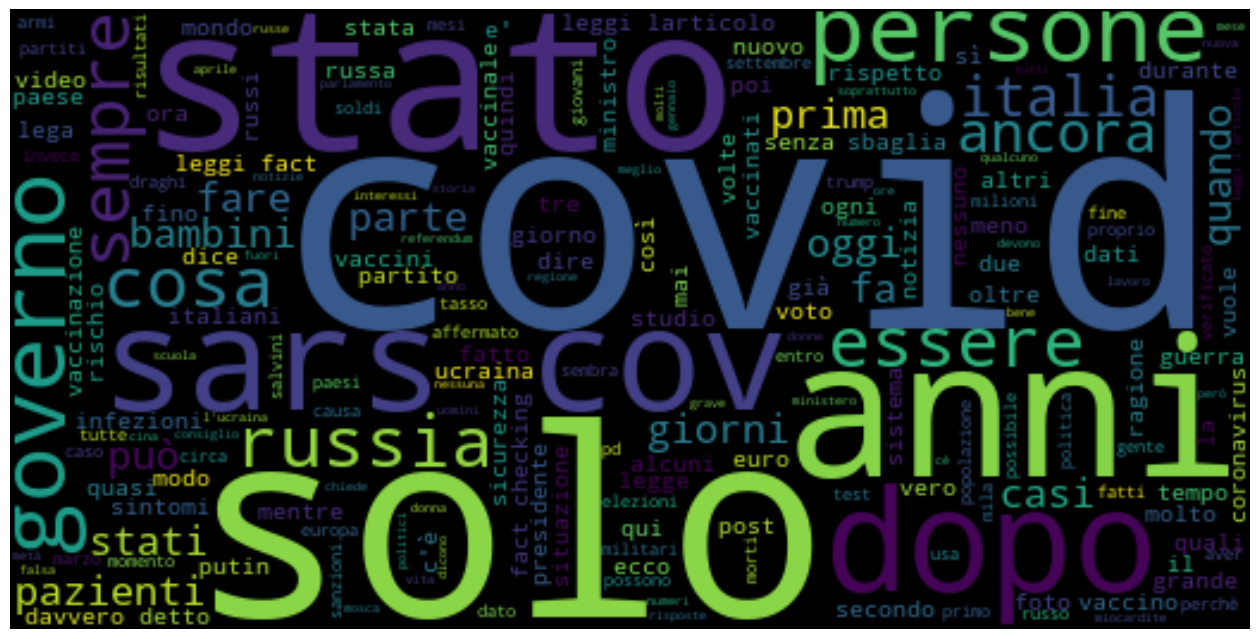

In [96]:
not_conspiratorial_msg_cloud = WordCloud(width=520,
                                     height=260,
                                     stopwords=STOPWORDS,
                                     #max_font_size=50,
                                     #background_color = "black", colormap = 'Pastel1'
                                     ).generate(not_conspiratorial_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(not_conspiratorial_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

In [97]:
max_length = 0
for post in list(df_dev.comment_text):
    post_length = len(post.split())
    # print(post_length)
    if post_length > max_length:
        max_length = post_length

In [98]:
max_length

364

In [99]:
X_dev = df_dev.comment_text.values

In [100]:
y_dev = df_dev.conspiratorial.values

In [101]:
len(X_dev), len(y_dev)

(1840, 1840)

# Data Splitting

In [102]:
# Extract a training & validation split
validation_split = 0.3
num_validation_samples = int(validation_split * len(X_dev))
num_validation_samples

552

In [103]:
X_train = X_dev[:-num_validation_samples]
len(X_train)

1288

In [104]:
num_test_samples = int(num_validation_samples/3)
num_test_samples

184

In [105]:
X_val = X_dev[-num_validation_samples:-num_test_samples]
len(X_val)

368

In [106]:
X_test = X_dev[-num_test_samples:]
len(X_test)

184

In [107]:
y_train = y_dev[:-num_validation_samples]
len(y_train)

1288

In [108]:
y_val = y_dev[-num_validation_samples:-num_test_samples]
len(y_val)

368

In [109]:
y_test = y_dev[-num_test_samples:]
len(y_test)

184

# Text Vectorization

In [110]:
vectorize_layer = TextVectorization(max_tokens=20000, # Max vocabulary size (to specifiy when adapting a vocabulary)
                                    output_sequence_length=max_length) # output dim padded or truncated => tensor of shape (batch_size, output_sequence_length)
text_ds = Dataset.from_tensor_slices(X_train)
text_ds

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [111]:
(list(text_ds.as_numpy_iterator()))[0]

b'soldati guerre.'

text_ds contiene tutti i post, ogni post è di tipo bytes.

In [112]:
vectorize_layer.adapt(text_ds.batch(64))

In [113]:
vectorize_layer.get_vocabulary()[:15]

['',
 '[UNK]',
 'covid',
 'stato',
 'solo',
 'persone',
 'essere',
 'anni',
 'dopo',
 'vaccino',
 'vaccini',
 'governo',
 'no',
 'cosa',
 'fatto']

In [114]:
vocabulary = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
len(vocabulary)

11769

## Word Embeddings

In [67]:
embedding_dim = 128

In [68]:
embeddings_path = '..\..\itwac128.txt'

In [69]:
def load_word_embeddings(emb_path):
    '''crea un dizionario contenente gli embedding di parole presente nel file src_path'''
    embeddings = dict() # dizionario che conterrà gli embedding
    for line in open(emb_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [70]:
embeddings = load_word_embeddings(embeddings_path)

In [71]:
len(embeddings)

1247492

In [72]:
len(embeddings[','])

128

### Creazione di una matrice di embeddings

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the embedding for the word of index i in our vectorizer's vocabulary.

In [73]:
len(vocabulary)

11769

In [115]:
def embedding_init(shape, dtype):
    num_tokens = shape[0]
    embedding_dim = shape[1]
    #num_tokens = len(vocabulary) + 2
    #embedding_dim = 128
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    # print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

# Model Building

In [116]:
from tensorflow.keras import Input

In [117]:
x_train = vectorize_layer(np.array([[s] for s in X_train])).numpy()
x_val = vectorize_layer(np.array([[s] for s in X_val])).numpy()
x_test = vectorize_layer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Embedding Layer Arguments

* input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
* output_dim: Integer. Dimension of the dense embedding.
* embeddings_initializer: Initializer for the embeddings matrix (see keras.initializers).
* embeddings_regularizer: Regularizer function applied to the embeddings matrix (see keras.regularizers).
* embeddings_constraint: Constraint function applied to the embeddings matrix (see keras.constraints).
* mask_zero: Boolean, whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent layers in the model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).
* input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
* sparse: If True, calling this layer returns a tf.SparseTensor. If False, the layer returns a dense tf.Tensor. For an entry with no features in a sparse tensor (entry with value 0), the embedding vector of index 0 is returned by default.

LSTM arguments:
* units: Positive integer, dimensionality of the output space.
* activation: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* recurrent_activation: Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [68]:
plot_model(model, to_file='LSTM_architecture.pdf', show_layer_names=False, show_layer_activations=True, rankdir='LR')

https://keras.io/examples/nlp/pretrained_word_embeddings/

In [118]:
from tensorflow.keras.optimizers import Adam

In [134]:
LSTM_HIDDEN_SIZE = [150, 200]
dense_size = [25, 50, 100, 150]
learning_rates = [0.00005] #, 0.00001]

# fatti: 0.00005 con 50/25, 50/50, 50/100, 50/150, 100/25

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 364, 128)          1506432   
                                                                 
 lstm_7 (LSTM)               (None, 150)               167400    
                                                                 
 dense_14 (Dense)            (None, 25)                3775      
                                                                 
 dense_15 (Dense)            (None, 2)                 52        
                                                                 
Total params: 1,677,659
Trainable params: 1,677,659
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
41/41 [==============================] - 19s 350ms/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6934 - val_accuracy: 0.4837
Epoch 2/100
41/41 [========

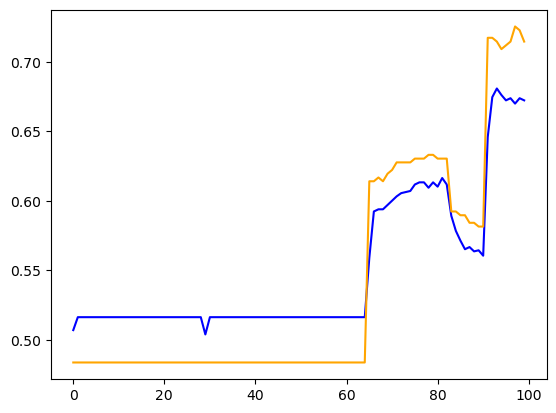

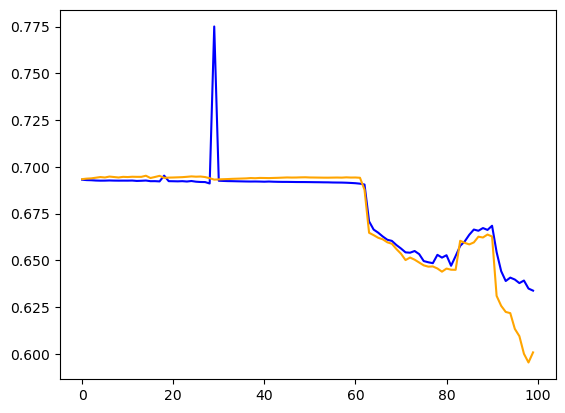

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 364, 128)          1506432   
                                                                 
 lstm_8 (LSTM)               (None, 150)               167400    
                                                                 
 dense_16 (Dense)            (None, 50)                7550      
                                                                 
 dense_17 (Dense)            (None, 2)                 102       
                                                                 
Total params: 1,681,484
Trainable params: 1,681,484
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
41/41 [==============================] - 19s 383ms/step - loss: 0.6931 - accuracy: 0.5109 - val_loss: 0.6936 - val_accuracy: 0.4837
Epoch 2/100
41/41 [========

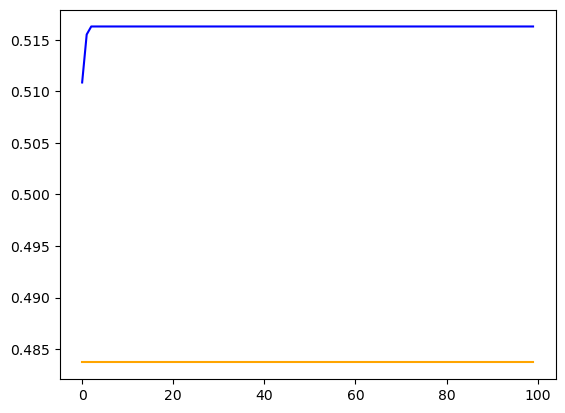

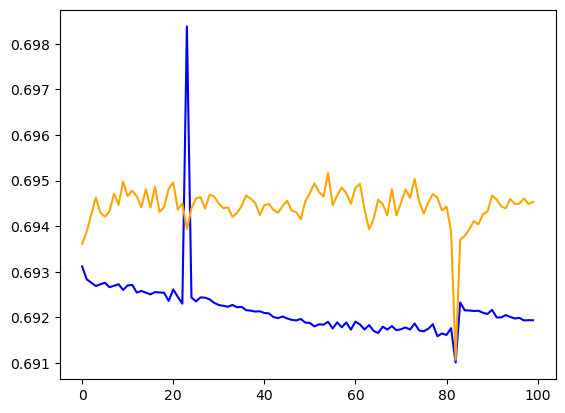

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 364, 128)          1506432   
                                                                 
 lstm_9 (LSTM)               (None, 150)               167400    
                                                                 
 dense_18 (Dense)            (None, 100)               15100     
                                                                 
 dense_19 (Dense)            (None, 2)                 202       
                                                                 
Total params: 1,689,134
Trainable params: 1,689,134
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
41/41 [==============================] - 19s 413ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4837
Epoch 2/100
41/41 [========

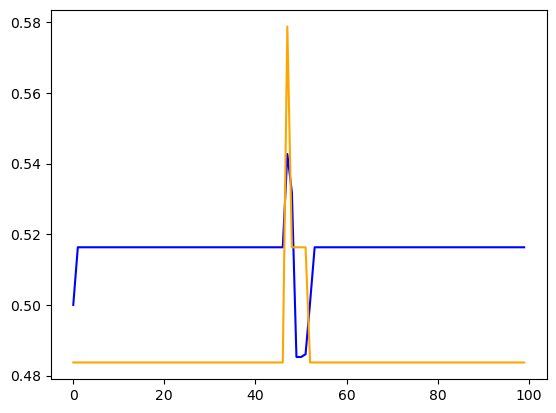

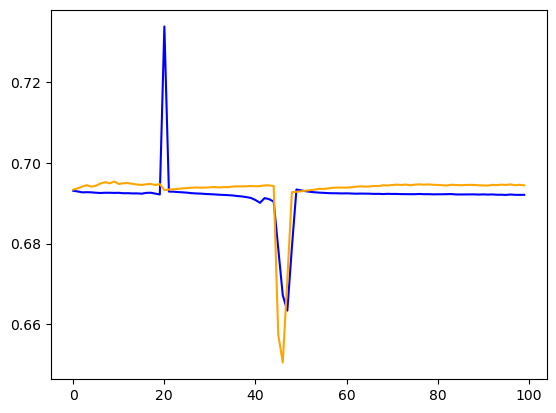

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 364, 128)          1506432   
                                                                 
 lstm_10 (LSTM)              (None, 150)               167400    
                                                                 
 dense_20 (Dense)            (None, 150)               22650     
                                                                 
 dense_21 (Dense)            (None, 2)                 302       
                                                                 
Total params: 1,696,784
Trainable params: 1,696,784
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
41/41 [==============================] - 20s 383ms/step - loss: 0.6935 - accuracy: 0.4790 - val_loss: 0.6932 - val_accuracy: 0.4837
Epoch 2/100
41/41 [=======

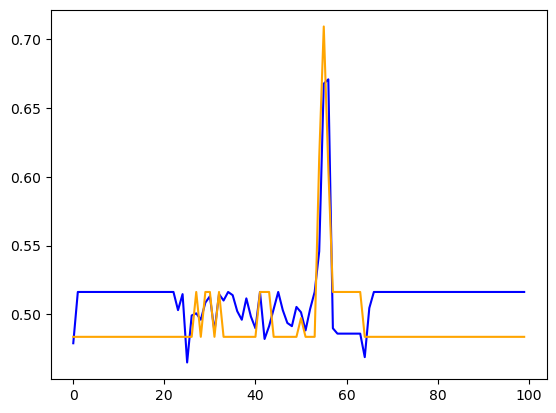

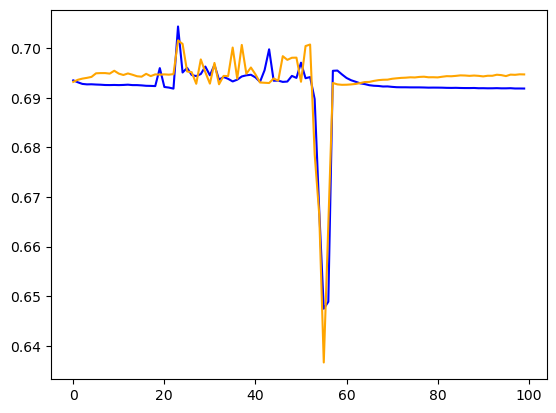

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 364, 128)          1506432   
                                                                 
 lstm_11 (LSTM)              (None, 200)               263200    
                                                                 
 dense_22 (Dense)            (None, 25)                5025      
                                                                 
 dense_23 (Dense)            (None, 2)                 52        
                                                                 
Total params: 1,774,709
Trainable params: 1,774,709
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
41/41 [==============================] - 23s 509ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6935 - val_accuracy: 0.4837
Epoch 2/100
41/41 [=======

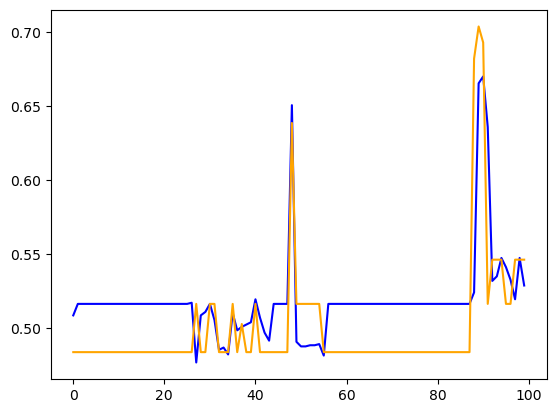

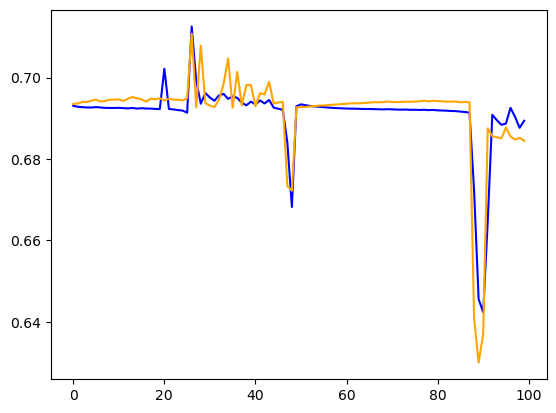

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 364, 128)          1506432   
                                                                 
 lstm_12 (LSTM)              (None, 200)               263200    
                                                                 
 dense_24 (Dense)            (None, 50)                10050     
                                                                 
 dense_25 (Dense)            (None, 2)                 102       
                                                                 
Total params: 1,779,784
Trainable params: 1,779,784
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
41/41 [==============================] - 27s 598ms/step - loss: 0.6931 - accuracy: 0.5047 - val_loss: 0.6936 - val_accuracy: 0.4837
Epoch 2/100
41/41 [=======

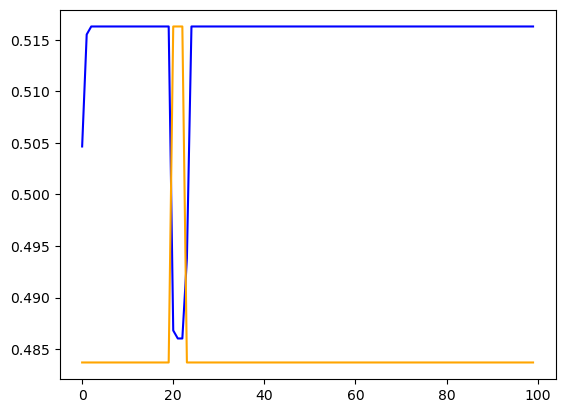

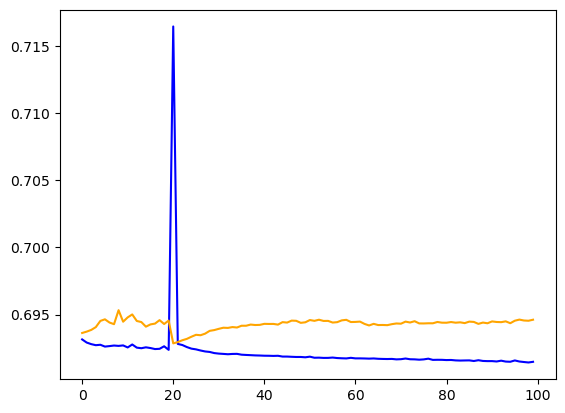

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 364, 128)          1506432   
                                                                 
 lstm_13 (LSTM)              (None, 200)               263200    
                                                                 
 dense_26 (Dense)            (None, 100)               20100     
                                                                 
 dense_27 (Dense)            (None, 2)                 202       
                                                                 
Total params: 1,789,934
Trainable params: 1,789,934
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
41/41 [==============================] - 26s 584ms/step - loss: 0.6930 - accuracy: 0.5140 - val_loss: 0.6936 - val_accuracy: 0.4837
Epoch 2/100
41/41 [=======

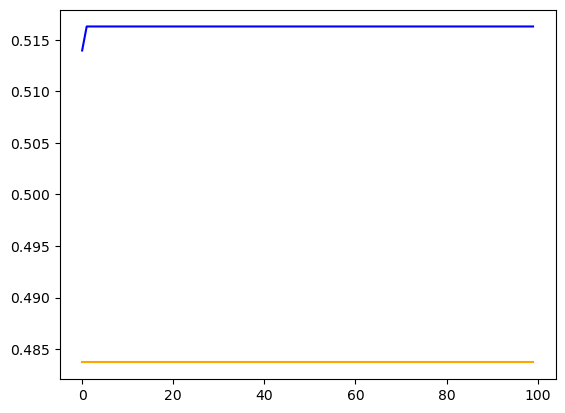

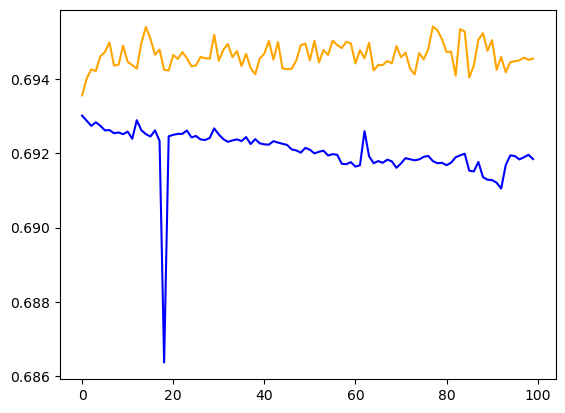

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 364, 128)          1506432   
                                                                 
 lstm_14 (LSTM)              (None, 200)               263200    
                                                                 
 dense_28 (Dense)            (None, 150)               30150     
                                                                 
 dense_29 (Dense)            (None, 2)                 302       
                                                                 
Total params: 1,800,084
Trainable params: 1,800,084
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
41/41 [==============================] - 27s 594ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4837
Epoch 2/100
41/41 [=======

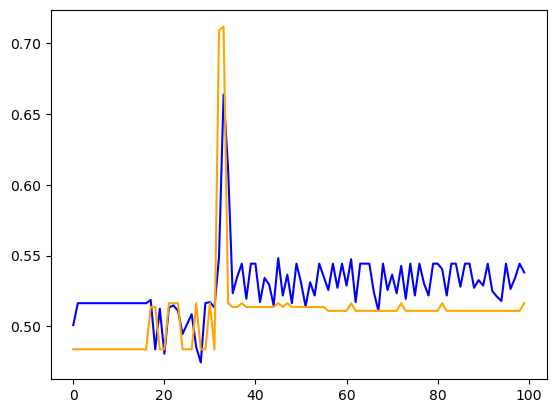

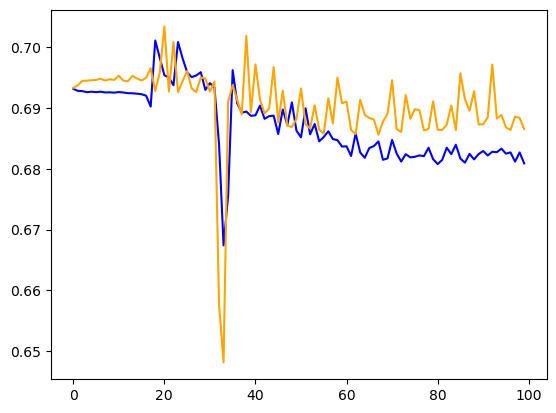

In [135]:
histories_big_LSTM = {}
for i in learning_rates: #dropout_value in dropout_values:
    for lstm_units in LSTM_HIDDEN_SIZE:
        for dense_units in dense_size:
            model = Sequential()
            model.add(Embedding(
                input_dim = len(vocabulary),
                output_dim = embedding_dim,
                embeddings_initializer=embedding_init,
                input_length=max_length)) 
                #mask_zero=True)) # 0-padding should be masked out
            model.add(LSTM(lstm_units)) #, dropout=0.2, recurrent_dropout=0.2))
            #model.add(Dropout(dropout_value))
            model.add(Dense(dense_units))
            model.add(Dense(2, activation='softmax'))
            print(model.summary())
            # plot_model(model, show_shapes=True)
            model.compile(
                loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=i),
                metrics=['accuracy'])
            history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))
            histories_big_LSTM[f'lr:{i}_lstm{lstm_units}_dense{dense_units}'] = history.history
            plt.plot(history.history['accuracy'], color='blue')
            plt.plot(history.history['val_accuracy'], color='orange')
            plt.show()
            plt.plot(history.history['loss'], color='blue')
            plt.plot(history.history['val_loss'], color='orange')
            plt.show()

In [159]:
histories.keys()

dict_keys(['lr:5e-05_lstm100_dense50', 'lr:5e-05_lstm100_dense100', 'lr:5e-05_lstm100_dense150'])

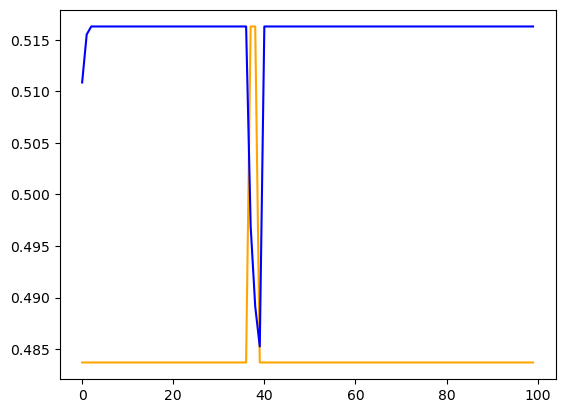

In [160]:
plt.plot(histories['lr:5e-05_lstm100_dense100']['val_accuracy'], color='orange')
plt.plot(histories['lr:5e-05_lstm100_dense100']['accuracy'], color='blue')

In [148]:
print(histories_big_LSTM['lr:5e-05_lstm150_dense25']['val_accuracy'])

[0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.4836956560611725,